In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import json

## Storing events offline

In [167]:
QUERY_COUNT = 0 # The queries are rate limited, so this can go over 200, I think

def get_hour(date, hour, type_="created"):
    # Get all events and return a df of type type_ within [hour, hour+1) of that date
    date = pd.Timestamp(date)
    t0 = pd.Timestamp("1970-01-01")
    
    date_start = (date + pd.DateOffset(days=0, hours=hour) - t0) // pd.Timedelta("1s")
    date_end = (date + pd.DateOffset(days=0, hours=hour + 1, seconds=-1) - t0) // pd.Timedelta('1s')
    LIMIT = 300 # Max limit for event queries is 300!
    
    df = pd.DataFrame()
    global QUERY_COUNT
    q = 0
    while True:
        url = f"https://api.opensea.io/api/v1/events?event_type={type_}&offset={q*LIMIT}&limit={LIMIT}&only_opensea=false&occurred_before={date_end}&occurred_after={date_start}"
        headers = {"Accept": "application/json"}
        response = requests.request("GET", url, headers=headers)
        
        if "asset_events" not in response.json() or response.json()["asset_events"] == []:
            break
        
        df = df.append(response_to_df(response).assign(date=date), ignore_index=True)
            
        QUERY_COUNT += 1
        q += 1
        #if QUERY_COUNT >= 200:
        #    print("Query count exceeded!")
        #    return 200
    return df

In [163]:
def response_to_df(response):
    # Clean up the response.json() a bit, it has some nasty dict entries
    df = pd.DataFrame(response.json()['asset_events'])
    seller = df["seller"].apply(lambda x: x["user"] if x is not None else None)
    seller = seller.apply(lambda x: x["username"] if x is not None else None)
    df["seller"] = seller
    
    from_ = df["from_account"].apply(lambda x: x["user"] if x is not None else None)
    from_ = from_.apply(lambda x: x["username"] if x is not None else None)
    df["from_account"] = from_
    df.drop(columns="asset", inplace=True)
    df.drop(columns="payment_token", inplace=True)
    return df

In [172]:
def save_df(df, file_name, append=True):
    # Save df to a .csv, supports appending
    if append and os.path.exists(file_name):
        df_read = pd.read_csv(file_name, index_col=False)
        df_read = df_read.append(df, ignore_index=True)
        #df_read.drop_duplicates(keep="first", inplace=True) # Doesn't work for some reason! also breaks with dict
        df_read.to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, index=False)   

In [173]:
for i in range(24):
    date = pd.Timestamp("2021-10-25")
    df_add = get_hour(date, i)
    save_df(df_add, "created-" + date.strftime("%Y-%m-%d") + ".csv")

C:\Users\taavet\AppData\Local\Temp/ipykernel_22584/91393372.py:4: DtypeWarning: Columns (14,21) have mixed types.Specify dtype option on import or set low_memory=False.
  save_df(df_add, "created-" + date.strftime("%Y-%m-%d") + ".csv")


JSONDecodeError: Expecting value: line 2 column 1 (char 1)

In [164]:
df = get_hour("2021-10-25", 3)

In [174]:
QUERY_COUNT

825

In [166]:
print(len(df))

10250


### Offline data creation end

In [20]:
date = pd.Timestamp("2021-10-25")
t0 = pd.Timestamp("1970-01-01")
date_start = (date - t0) // pd.Timedelta('1s')
date_end = (date + pd.DateOffset(days=0, hours=1, seconds=-1) - t0) // pd.Timedelta('1s')
url = f"https://api.opensea.io/api/v1/events?event_type=created&offset=15000&limit=300&only_opensea=false&occurred_before={date_end}&occurred_after={date_start}"

In [145]:
created_df['starting_price'] = created_df['starting_price'].apply(int)/10**18
created_df['US_Dollar_Price'] = created_df['starting_price'] * 4195
created_df["created_date"] = pd.to_datetime(created_df["created_date"])
created_df.drop(created_df[created_df["starting_price"]==0].index, inplace=True)

In [152]:
min_date = created_df.groupby("timestamp")["created_date"].min() # Groupby is suuuuper convenient. iirc you can also pass it lambdas for the functions you want to apply
max_date = created_df.groupby("timestamp")["created_date"].max()
measurement_duration = max_date - min_date
#print(measurement_duration)
rate = created_df.groupby("timestamp").size() / (measurement_duration // pd.Timedelta("1s"))
#print(rate)

Text(0.5, 1.0, 'NFT events per second')

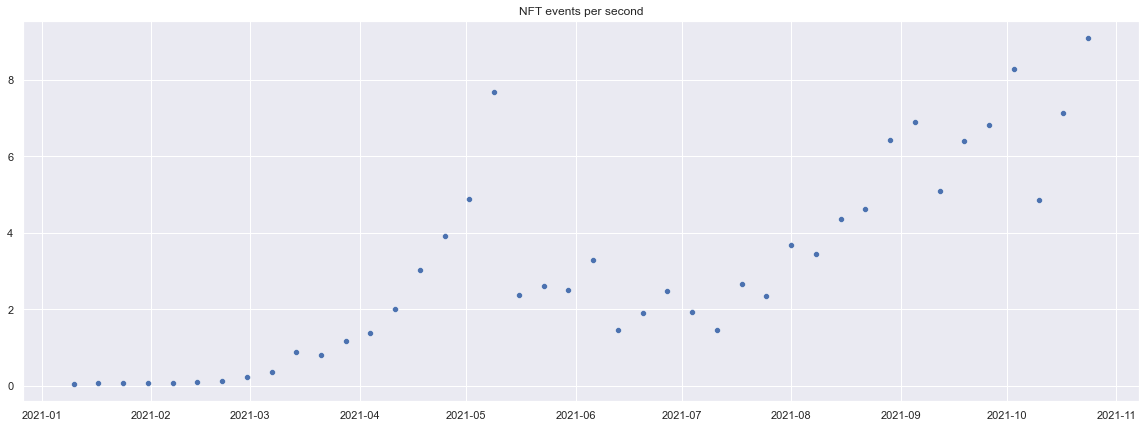

In [151]:
ax = sns.scatterplot(x=dates_, y=rate.values)
ax.set_title("NFT events per second")
#ax.set_yscale('log')

(1e-06, 1000)

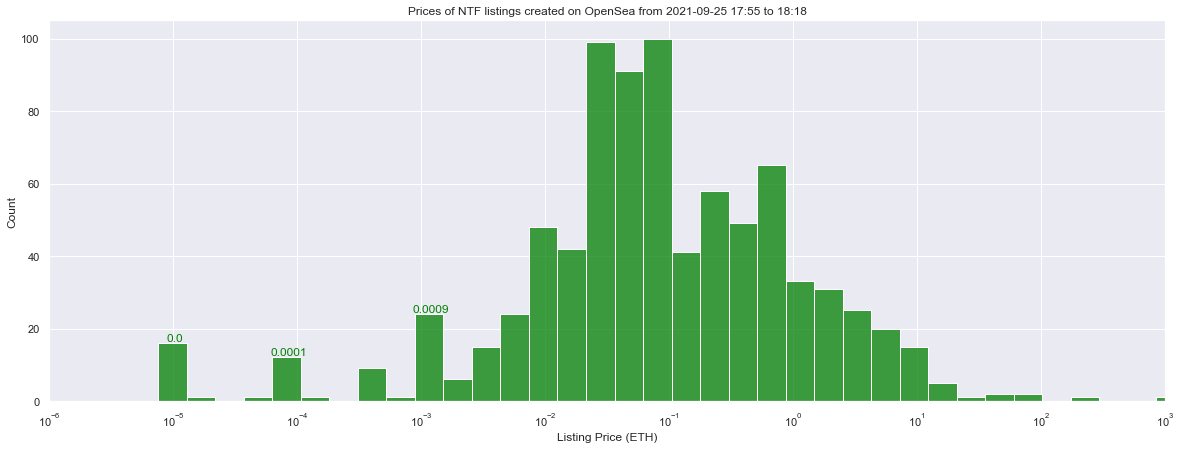

In [42]:
fig, ax = plt.subplots()
sns.histplot(created_df['starting_price'].values, bins = 100, log_scale=True, color = 'green')
sns.set(rc={'figure.figsize': (20, 7)})
plt.xlabel('Listing Price (ETH)')
plt.title('Prices of NTF listings created on OpenSea from 2021-09-25 17:55 to 18:18')

for p in ax.patches[38:66]:
    if p.get_height() > 10:
        if p.get_x()>10:
            ax.text(p.get_x() + p.get_width() / 2.,
                    p.get_height(),
                    round(p.get_x(), 1),
                    fontsize=12,
                    color='green',
                    ha='center',
                    va='bottom')
        else:
            ax.text(p.get_x() + p.get_width() / 2.,
                    p.get_height(),
                    round(p.get_x(),4),
                    fontsize=12,
                    color='green',
                    ha='center',
                    va='bottom')
ax.set_xlim(0.000001, 1000)


(0.001, 10000000)

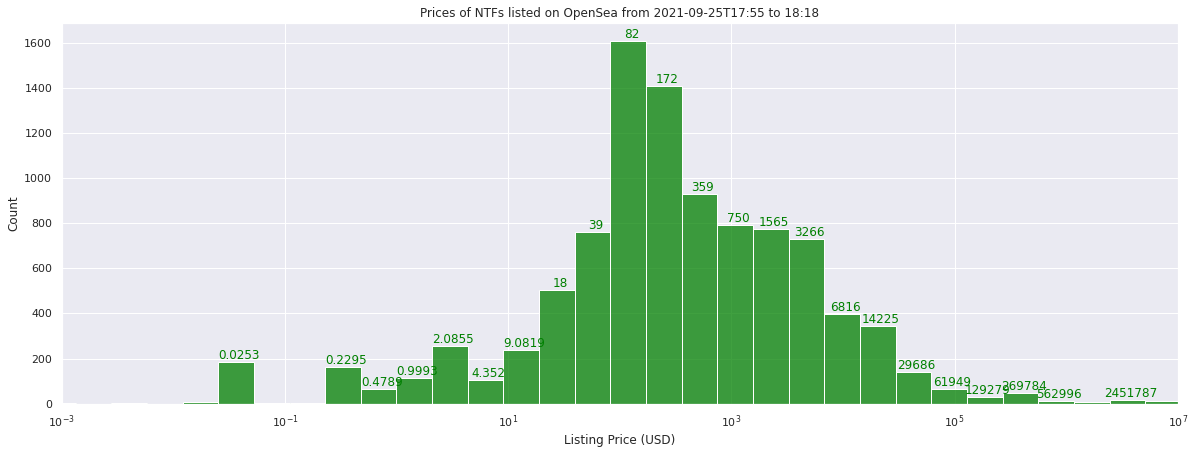

In [200]:
fig, ax = plt.subplots()
sns.histplot(created_df['US_Dollar_Price'],
             bins=100,
             log_scale=True,
             color='green')
sns.set(rc={'figure.figsize': (20, 7)})
plt.xlabel('Listing Price (USD calculated at 2021-10-25 exchange rates)')
plt.title('Prices of NTF listings created on OpenSea from 2021-09-25 17:55 to 18:18')

for p in ax.patches[38:66]:
    if p.get_height() > 10:
        if p.get_x() > 10:
            ax.text(p.get_x() + p.get_width() / 2.,
                    p.get_height(),
                    int(p.get_x()),
                    fontsize=12,
                    color='green',
                    ha='center',
                    va='bottom')
        else:
            ax.text(p.get_x() + p.get_width() / 2.,
                    p.get_height(),
                    round(p.get_x(), 4),
                    fontsize=12,
                    color='green',
                    ha='center',
                    va='bottom')
ax.set_xlim(0.001, 10000000)


In [187]:
created_df['created_date'] = pd.to_datetime(created_df['created_date'])

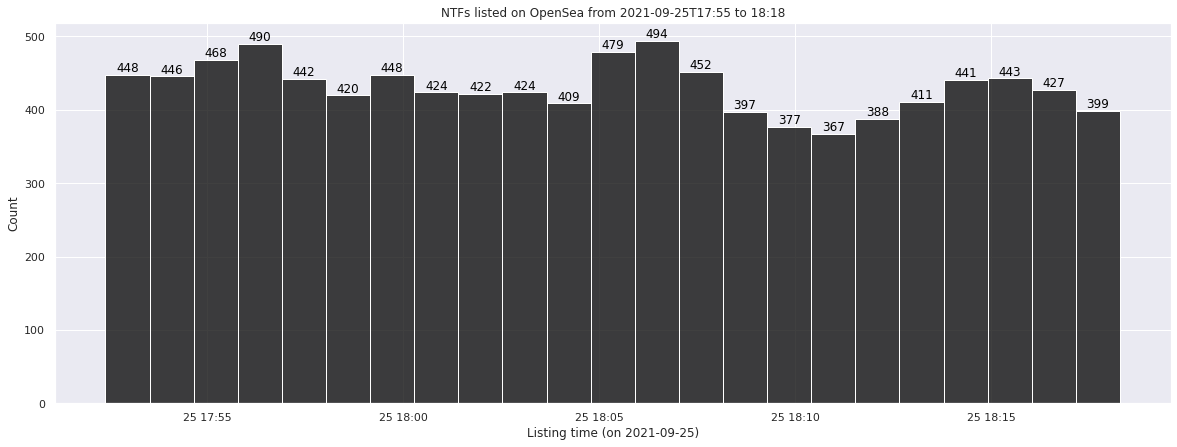

In [193]:
fig, ax = plt.subplots()
sns.histplot(created_df['created_date'],
            bins=23,
            color = 'black'
            )
sns.set(rc={'figure.figsize': (20, 7)})
plt.xlabel('Listing time (on 2021-09-25)')
plt.title('NTFs listed on OpenSea from 2021-09-25 17:55 to 18:18')
for p in ax.patches:
    if p.get_height() != 0:
        ax.text(p.get_x() + p.get_width() / 2.,
                p.get_height(),
                int(p.get_height()),
                fontsize=12,
                color='black',
                ha='center',
                va='bottom')


# NFTs Sold

In [33]:
import requests

sold_df = pd.DataFrame()
until_date = 1635195005
for i in range(200):

    url = f"https://api.opensea.io/api/v1/events?event_type=successful&only_opensea=false&offset=0&limit=50&occurred_before={until_date}"

    headers = {"Accept": "application/json"}

    response = requests.request("GET", url, headers=headers)
    date = pd.to_datetime(
        pd.DataFrame(response.json()['asset_events']).sort_values(
            'created_date', ascending=False)[49:]['created_date'])

    until_date = (date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    until_date = until_date.values[0]
    sold_df = sold_df.append(
        pd.DataFrame(response.json()['asset_events']))


In [29]:
sold_df[;]

85

In [32]:
pd.DataFrame(response.json()['asset_events']).sort_values('created_date', ascending = False)


,approved_account,asset,asset_bundle,auction_type,bid_amount,collection_slug,contract_address,created_date,custom_event_name,dev_fee_payment_event,...,is_private,owner_account,payment_token,quantity,seller,starting_price,to_account,total_price,transaction,winner_account
12,None,"{'id': 18300920, 'token_id': '5789604461865809...",None,None,None,pills,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:23.897612,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': 'NFT100x'}, 'profile_img...",None,None,1375000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d95de...,"{'user': None, 'profile_img_url': 'https://sto..."
11,None,"{'id': 73633805, 'token_id': '3714', 'num_sale...",None,None,None,billionaireclubnft,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:23.702840,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': None}, 'profile_img_url'...",None,None,550000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d95de...,"{'user': {'username': 'StanfordWorks'}, 'profi..."
10,None,"{'id': 80399234, 'token_id': '5006', 'num_sale...",None,None,None,pumpkinheads-v2-1,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:23.681323,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': 'Pogboom'}, 'profile_img...",None,None,35000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d95de...,"{'user': {'username': 'illiquid_eth'}, 'profil..."
9,None,"{'id': 80980886, 'token_id': '1', 'num_sales':...",None,None,None,polarbearsnft,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:23.384728,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': 'Sunny-'}, 'profile_img_...",None,None,129000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d95de...,"{'user': {'username': '0x1d66'}, 'profile_img_..."
8,None,"{'id': 34996293, 'token_id': '3481', 'num_sale...",None,None,None,cryptodickbutts-s3,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:23.175448,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': 'cryptopenks_vault'}, 'p...",None,None,670000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d95de...,"{'user': {'username': 'j_booze'}, 'profile_img..."
7,None,"{'id': 80399271, 'token_id': '5009', 'num_sale...",None,None,None,pumpkinheads-v2-1,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:23.173185,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': 'Pogboom'}, 'profile_img...",None,None,35000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d95de...,"{'user': {'username': 'illiquid_eth'}, 'profil..."
6,None,"{'id': 80492189, 'token_id': '251', 'num_sales...",None,None,None,z-huge,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:23.028329,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': 'NF2C'}, 'profile_img_ur...",None,None,1200000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d95de...,"{'user': {'username': 'HasMoreSushi'}, 'profil..."
5,None,"{'id': 73027829, 'token_id': '2629', 'num_sale...",None,None,None,huxley-comics,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:22.850305,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': 'CaliHodlr'}, 'profile_i...",None,None,100000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d95de...,"{'user': {'username': 'one_kiel'}, 'profile_im..."
4,None,"{'id': 74875573, 'token_id': '8382', 'num_sale...",None,None,None,partydegenerates,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,2021-10-25T20:49:22.617568,None,None,...,False,None,"{'id': 1, 'symbol': 'ETH', 'address': '0x00000...",1,"{'user': {'username': 'Logical'}, 'profile_img...",None,None,880000000000000000,{'block_hash': '0xdfbc456eef223a78c2b00f4d

In [144]:
created_df = pd.DataFrame()
repeats = 4
limit = 50

for timestamp in timestamps:
    for i in range(repeats):
        url = f"https://api.opensea.io/api/v1/events?event_type=created&only_opensea=false&offset={i*limit}&limit={limit}&occurred_before={timestamp}"

        headers = {"Accept": "application/json"}
        response = requests.request("GET", url, headers=headers)
        created_df = created_df.append(pd.DataFrame(response.json()['asset_events']).assign(timestamp=timestamp), ignore_index=True)
    